<a href="https://colab.research.google.com/github/sknjoroge/cancer-logistic-regression/blob/main/TrafficControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/smart_traffic_management_dataset.csv')
print("Shape:", df.shape)
df.head()

Shape: (2000, 12)


,timestamp,location_id,traffic_volume,avg_vehicle_speed,vehicle_count_cars,vehicle_count_trucks,vehicle_count_bikes,weather_condition,temperature,humidity,accident_reported,signal_status
0,2024-01-01 00:00:00,4,504,53.124162,142,24,44,Cloudy,33.334387,36.390698,0,Red
1,2024-01-01 00:01:00,5,209,44.947850,862,50,23,Cloudy,17.926830,37.640927,0,Green
2,2024-01-01 00:02:00,3,572,63.179229,317,12,10,Windy,33.483375,84.262610,1,Red
3,2024-01-01 00:03:00,5,699,42.269697,709,43,21,Sunny,19.212941,61.550978,0,Yellow
4,2024-01-01 00:04:00,5,639,72.185791,594,34,14,Cloudy,11.349244,77.494506,0,Red


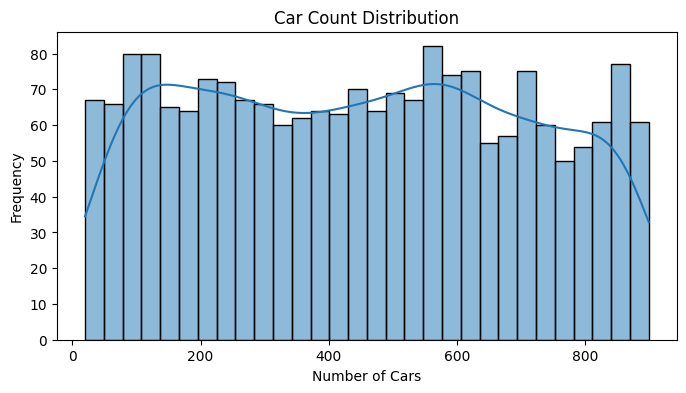

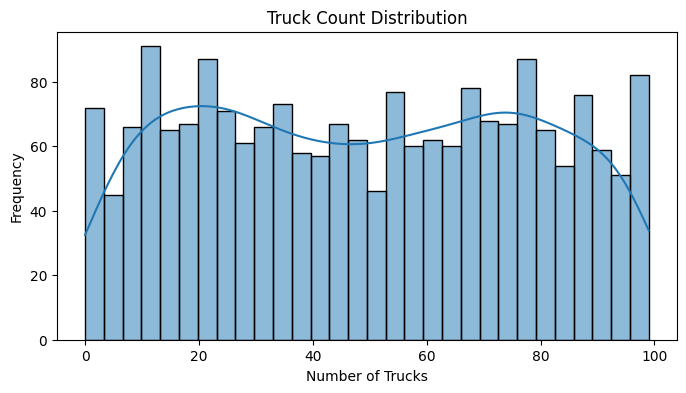

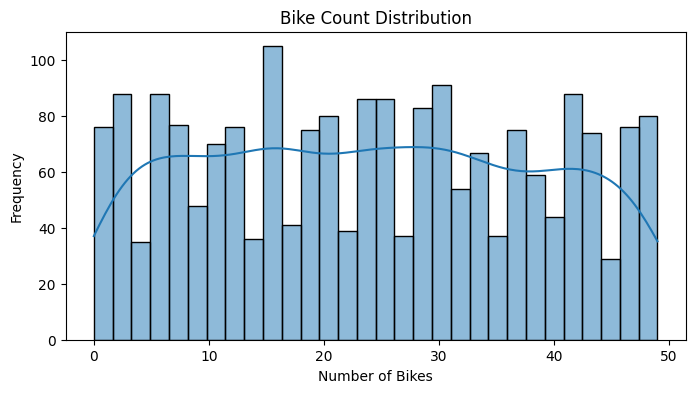

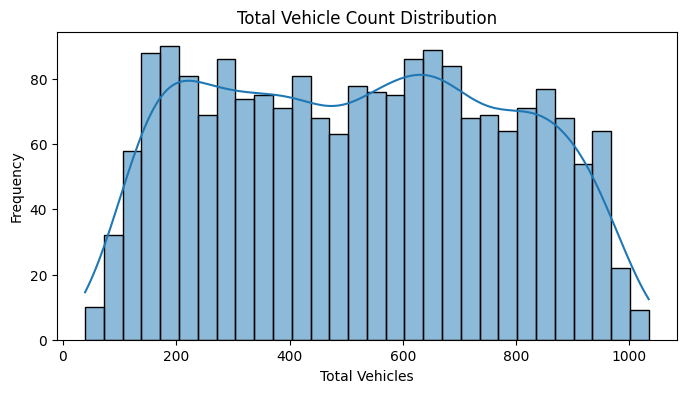

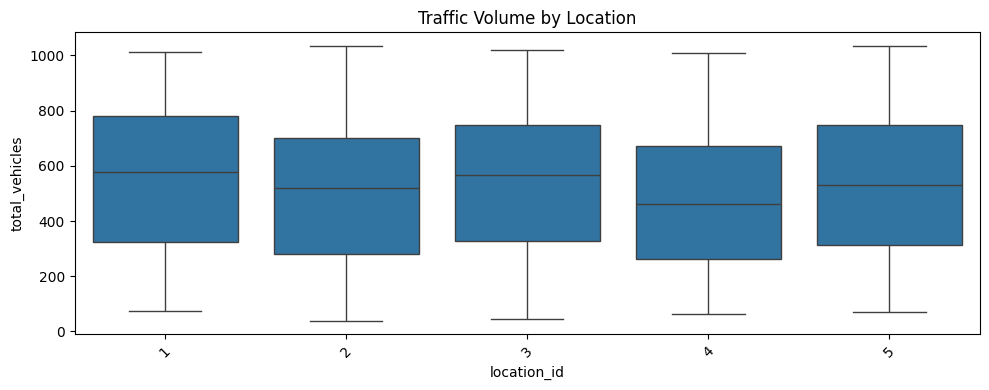

In [3]:
# Vehicle count distribution (cars, trucks, bikes)
plt.figure(figsize=(8, 4))
sns.histplot(df['vehicle_count_cars'], bins=30, kde=True)
plt.title("Car Count Distribution")
plt.xlabel("Number of Cars")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['vehicle_count_trucks'], bins=30, kde=True)
plt.title("Truck Count Distribution")
plt.xlabel("Number of Trucks")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['vehicle_count_bikes'], bins=30, kde=True)
plt.title("Bike Count Distribution")
plt.xlabel("Number of Bikes")
plt.ylabel("Frequency")
plt.show()

# Total vehicle count distribution
df['total_vehicles'] = df['vehicle_count_cars'] + df['vehicle_count_trucks'] + df['vehicle_count_bikes']
plt.figure(figsize=(8, 4))
sns.histplot(df['total_vehicles'], bins=30, kde=True)
plt.title("Total Vehicle Count Distribution")
plt.xlabel("Total Vehicles")
plt.ylabel("Frequency")
plt.show()

# Traffic by Location
plt.figure(figsize=(10, 4))
sns.boxplot(x='location_id', y='total_vehicles', data=df)
plt.title("Traffic Volume by Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Feature Engineering
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['Hour'] = df['timestamp'].dt.hour
df['Day'] = df['timestamp'].dt.day
df['Month'] = df['timestamp'].dt.month
df['DayOfWeek'] = df['timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['IsPeak'] = df['Hour'].apply(lambda x: 1 if 7 <= x <= 9 or 17 <= x <= 19 else 0)

# Label encoding for location_id and other categorical columns
le = LabelEncoder()
df['location_id'] = le.fit_transform(df['location_id'])
df['weather_condition'] = le.fit_transform(df['weather_condition'])
df['accident_reported'] = le.fit_transform(df['accident_reported'].astype(str))
df['signal_status'] = le.fit_transform(df['signal_status'].astype(str))

df.drop(columns=['timestamp'], inplace=True)
df.fillna(method='ffill', inplace=True)

In [5]:
# Label encoding for weather_condition
le_weather = LabelEncoder()
df['weather_condition'] = le_weather.fit_transform(df['weather_condition'])

# If you have other categorical columns, apply LabelEncoder to them as well
df['accident_reported'] = le_weather.fit_transform(df['accident_reported'].astype(str))
df['signal_status'] = le_weather.fit_transform(df['signal_status'].astype(str))

In [6]:
print(df.columns)

Index(['location_id', 'traffic_volume', 'avg_vehicle_speed',
       'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes',
       'weather_condition', 'temperature', 'humidity', 'accident_reported',
       'signal_status', 'total_vehicles', 'Hour', 'Day', 'Month', 'DayOfWeek',
       'IsWeekend', 'IsPeak'],
      dtype='object')


In [7]:
X = df.drop('total_vehicles', axis=1)
y = df['total_vehicles']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
rf = RandomForestRegressor(random_state=42)
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(rf, params, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", grid.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 8.37015
R² Score: 0.9981896134053346


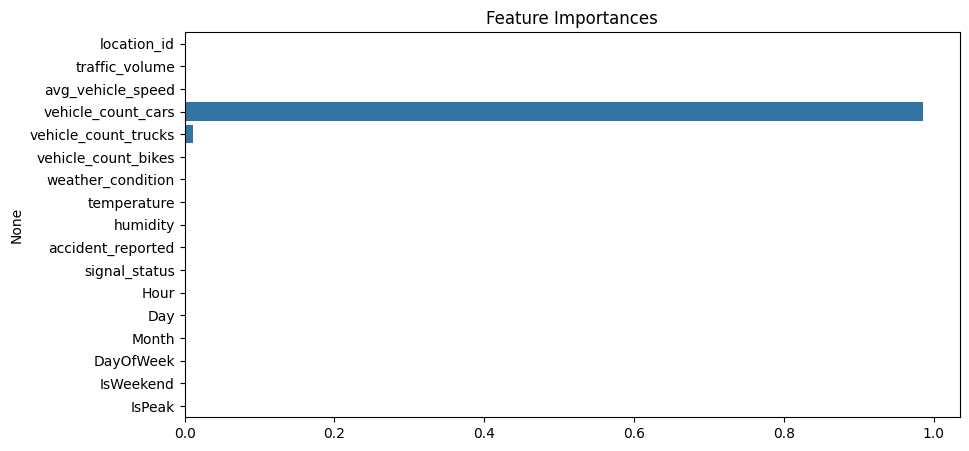

In [10]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()

In [11]:
def signal_strategy(pred):
    if pred > 300:
        return "🔴 Critical congestion – activate alternate route and extend green by 60s"
    elif pred > 150:
        return "🟠 Heavy – extend green by 30s"
    elif pred > 70:
        return "🟡 Moderate – keep normal timings"
    else:
        return "🟢 Low – reduce green or allow pedestrian cycle"

# Apply strategy to top 10 predictions
for i in range(50):
    print(f"Vehicles: {y_pred[i]:.2f} → {signal_strategy(y_pred[i])}")

Vehicles: 799.82 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 664.08 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 681.29 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 423.36 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 292.63 → 🟠 Heavy – extend green by 30s
Vehicles: 733.04 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 219.35 → 🟠 Heavy – extend green by 30s
Vehicles: 726.82 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 424.78 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 753.48 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 292.49 → 🟠 Heavy – extend green by 30s
Vehicles: 675.72 → 🔴 Critical congestion – activate alternate route and extend green by 60s
Vehicles: 797.99 → 🔴 Crit

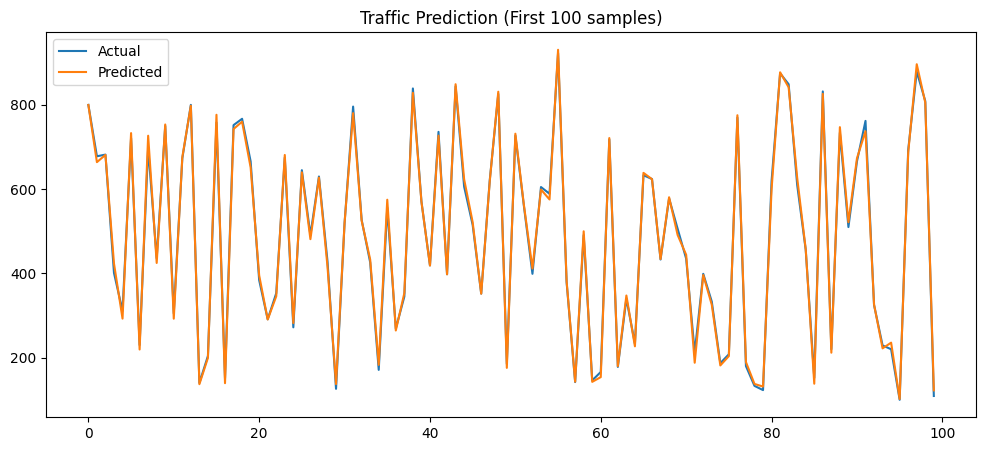

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title("Traffic Prediction (First 100 samples)")
plt.legend()
plt.show()